In [3]:
%pylab inline
import numpy as np
import pylab as pb
import GPy

Populating the interactive namespace from numpy and matplotlib


## Multiputput Hierarchical Gp's and deeper hierarchies

In this notebook we will combine the multioutput GP's with the hierarchical modelling using the ICM and a three layers hierarchy, mainly thed ata has to be synthetically generated. 

### Creating Syntethic Data with ICM of GPy

Thus, we generate the first subject of the hierarchy

(15,) (15,)


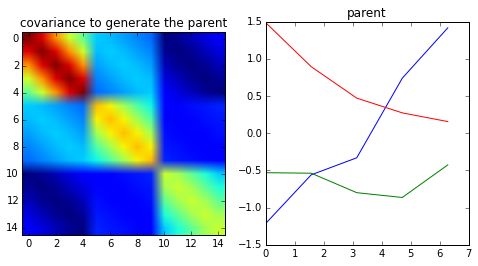

In [18]:
x_cluster = np.linspace(0, 2*np.pi, time_stamps)
inp = x_cluster[:, None]
T = np.r_[np.c_[inp, np.zeros_like(inp)]]
for i in range(1,d):
    T = np.r_[T, np.c_[inp, np.ones_like(inp)*i]]        

C_cluster_gen = k_cluster_gen.K(T, None)
plt.figure(1, figsize=(8,4))
plt.subplot(1,2,1)
plt.title('covariance to generate the parent')
plt.imshow(C_cluster_gen)

g_mean = np.zeros(T.shape[0])
g_n = np.random.multivariate_normal(g_mean, C_cluster_gen, 1)
divs = np.linspace(0,d*time_stamps, d + 1)
print T[0:50,0].shape, g_n[0, 0:50].shape
plt.subplot(1,2,2)
plt.title('parent')
for i in range(0, divs.shape[0] - 1):
    a = divs[i]
    b = divs[i+1]
    plt.plot(T[a:b,0], g_n[0,a:b])

adding the second layer

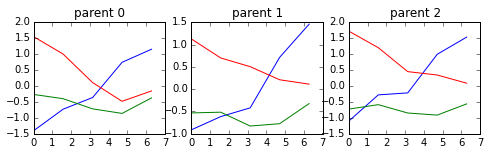

In [19]:
fn_list = []
C_parent_gen = k_parent_gen.K(T, None)
g_n = g_n.squeeze()
plt.figure(1, figsize=(8,2))
for i in range(0,n_sons):
    f_n = np.random.multivariate_normal(g_n, C_parent_gen, 1)
    f_n = np.squeeze(f_n)
    fn_list.append(f_n)
    pb.subplot(n_sons/3, 3, i + 1)
    pb.title('parent '+str(i))
    for j in range(0, divs.shape[0] - 1):
        a = divs[j]
        b = divs[j+1]
        pb.plot(T[a:b,0], f_n[a:b])

adding the third layer

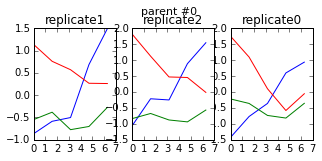

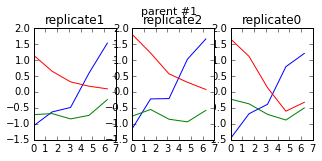

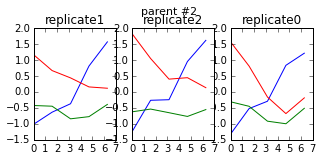

In [20]:
hn_list = []
n_replicates = 3
C_replicate_gen = k_replicate_gen.K(T, None)
for i in range(0,n_sons):
    mfig = plt.figure(i, figsize=(5,2))
    mfig.suptitle('parent #'+str(i), fontsize=11, verticalalignment='bottom')
    for k in range(0, n_replicates):
        h_n = np.random.multivariate_normal(fn_list[k], C_replicate_gen, 1)
        h_n = np.squeeze(h_n)
        hn_list.append(h_n)
        plt.subplot(1, n_replicates, k)
        plt.title('replicate' +str(k))
        for j in range(0, divs.shape[0] - 1):
            a = divs[j]
            b = divs[j+1]
            plt.plot(T[a:b,0], h_n[a:b])

Setting the input to the hierarchical model with the three layers

In [21]:
T_hat = np.c_[T, np.zeros_like(T[:,1]), np.zeros_like(T[:,1])]
T_hat = np.r_[T_hat, np.c_[T, np.zeros_like(T[:,1]), np.ones_like(T[:,1])]]
T_hat = np.r_[T_hat, np.c_[T, np.zeros_like(T[:,1]), np.ones_like(T[:,1])*2]]
Y_hat = np.c_[np.r_[hn_list[0], hn_list[1], hn_list[2]]]
count_gene = 1
count_replicate = 3
#print Y_hat
for i in range(3,len(hn_list)):
    if(count_replicate%n_replicates == 0 and count_replicate != 0):
        count_gene += 1
    T_hat = np.r_[T_hat, np.c_[T, np.ones_like(T[:,1])*count_gene, np.ones_like(T[:,1])*count_replicate]]
    Y_hat = np.r_[Y_hat, np.c_[hn_list[i]]]
    count_replicate += 1

#print T_hat

In [22]:
k1 = GPy.kern.Matern32(1, variance=5., lengthscale=20.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d-1)
k2 = GPy.kern.Matern32(1, variance=2., lengthscale=5.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d-1)
k3 = GPy.kern.Matern32(1, variance=1., lengthscale=2.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d-1)

kernels = [k1,k2,k3]
HGPkern = GPy.kern._src.independent_outputs.Hierarchical(kernels)
model = GPy.models.GPRegression(T_hat, Y_hat, HGPkern) # Making a normal regression
#model.likelihood.variance = 0.01
model.optimize('bfgs')#, messages=1)

With the inference then it's possible to make prediction over each parent(unobserved) and over all the tendency of the cluster.

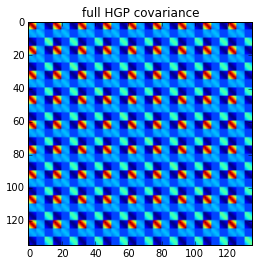

In [23]:
fullHGP_covariance = HGPkern.K(T_hat, None)
plt.imshow(fullHGP_covariance)
plt.title('full HGP covariance')